<a href="https://colab.research.google.com/github/objectis/ai-fashion-generator/blob/master/generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [0]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

## Config

In [0]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

## Generator model

In [0]:
def build_generator(img_shape,latent_dim):
  model = Sequential()

  model.add(Dense(256, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

## Discriminator model

In [0]:
def build_discriminator(img_shape):
  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

## GAN model

In [0]:
def build_gan(generator, discriminator,latent_dim):
  optimizer = Adam(lr=0.0002, beta_1=0.5)

  # compile the discriminator
  discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])


  z = Input(shape=(latent_dim,))
  img = generator(z)

  # only train the generator
  discriminator.trainable = False
  validity = discriminator(img)

  gan = Model(z, validity)
  gan.compile(loss='binary_crossentropy', optimizer=optimizer)

  return gan

## Building all together

In [30]:
generator = build_generator(img_shape,latent_dim)
discriminator = build_discriminator(img_shape)

gan = build_gan(generator, discriminator, latent_dim)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1024)             

## Training 
### Sampling images

In [0]:
def sample_images(epoch):
        r, c = 3, 3
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

### Training

In [0]:
def train(epochs, batch_size=128, sample_interval=200):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generate a batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = gan.train_on_batch(noise, valid)

            

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              sample_images(epoch)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.707570, acc.: 59.38%] [G loss: 0.759796]


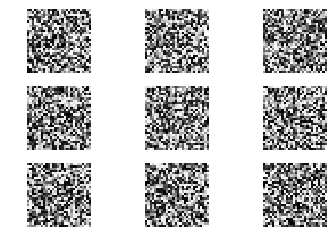

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2000 [D loss: 0.623325, acc.: 70.31%] [G loss: 0.955682]


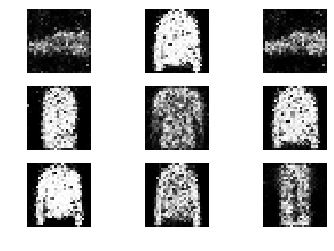

4000 [D loss: 0.592530, acc.: 76.56%] [G loss: 0.909543]


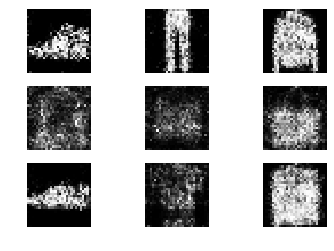

6000 [D loss: 0.692774, acc.: 62.50%] [G loss: 0.923049]


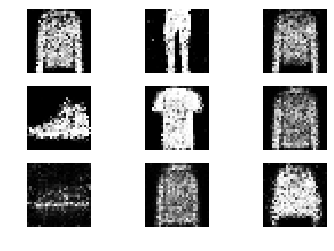

8000 [D loss: 0.688874, acc.: 51.56%] [G loss: 0.886725]


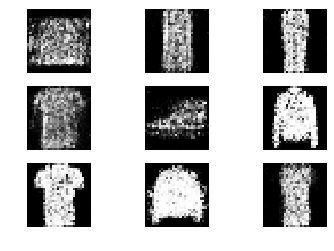

10000 [D loss: 0.677802, acc.: 60.94%] [G loss: 0.894039]


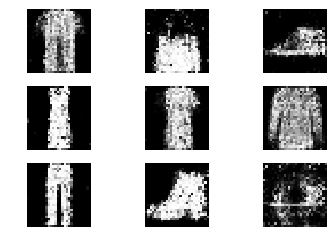

12000 [D loss: 0.622206, acc.: 65.62%] [G loss: 0.766026]


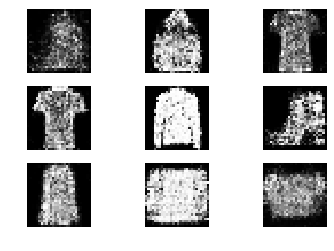

14000 [D loss: 0.687676, acc.: 51.56%] [G loss: 0.882534]


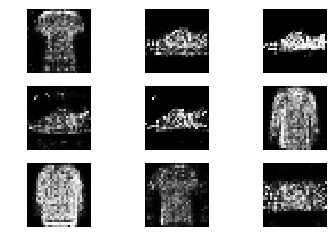

16000 [D loss: 0.633646, acc.: 67.19%] [G loss: 0.814895]


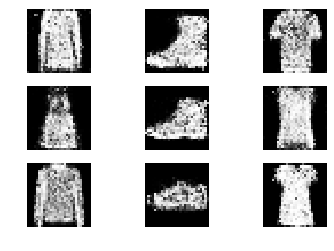

18000 [D loss: 0.612296, acc.: 64.06%] [G loss: 0.854862]


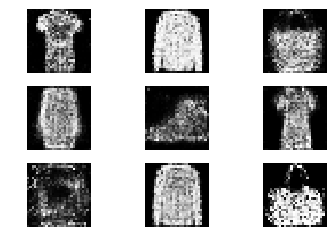

In [33]:
train(epochs=20000, batch_size=32,sample_interval=2000)